In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nibabel as nib
import cv2
from mlxtend.preprocessing import one_hot
import timeit
from random import shuffle
from MPC_tools import *
from layers import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


%matplotlib inline

# Making files path list

In [2]:
base_dir = '/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data'

In [3]:
dir_path_list = []
filenames_list = []

for dirpath, dirnames, filenames in os.walk(base_dir):
    if 'model' in dirpath:
        dir_path_list.append(dirpath)

        temp_filenames_list=[]
        for i in range(len(filenames)):
            if 'sub' and 'npy' in filenames[i]:
                temp_filenames_list.append(filenames[i])
        filenames_list.append(temp_filenames_list)
        
dir_path_list = np.array(dir_path_list)
filenames_list = np.array(filenames_list)
filenames_list = np.sort(filenames_list, axis=1)

full_path_list = []

for i in range(dir_path_list.shape[0]):
    temp_path_list=[]
    for j in range(len(filenames_list[i])):
        temp_path = os.path.join(dir_path_list[i], filenames_list[i][j])
        temp_path_list.append(temp_path)
    full_path_list.append(temp_path_list)

full_path_list = np.array(full_path_list)

In [4]:
dir_path_list

array(['/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data/model02_FIR_SPM_SINGLE_TRIAL',
       '/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data/model02_Overall_FIR_SPM_SINGLE_TRIAL'],
      dtype='<U88')

In [5]:
filenames_list.shape

(2, 58)

In [6]:
full_path_list

array([['/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data/model02_FIR_SPM_SINGLE_TRIAL/model02_FIR_SPM_SINGLE_TRIAL_sub-semic001.npy',
        '/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data/model02_FIR_SPM_SINGLE_TRIAL/model02_FIR_SPM_SINGLE_TRIAL_sub-semic002.npy',
        '/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data/model02_FIR_SPM_SINGLE_TRIAL/model02_FIR_SPM_SINGLE_TRIAL_sub-semic003.npy',
        '/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data/model02_FIR_SPM_SINGLE_TRIAL/model02_FIR_SPM_SINGLE_TRIAL_sub-semic004.npy',
        '/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data/model02_FIR_SPM_SINGLE_TRIAL/model02_FIR_SPM_SINGLE_TRIAL_sub-semic005.npy',
        '/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data/model02_FIR_SPM_SINGLE_TRIAL/model02_FIR_SPM_SINGLE_TRIAL_sub-semic006.npy',
        '/home/cocoan-gpu1/D_drive/MPC/data/SEMIC/numpy_data/model02_FIR_SPM_SINGLE_TRIAL/model02_FIR_SPM_SINGLE_TRIAL_sub-semic007.npy',
        '/home/cocoan-gpu1/D_drive

# Loading the data

In [7]:
def load_data(subjec_num, shuffle=False, nan_to_num=False, one_hot_y=False, flatten_X=False):
    import gc
    gc.collect()

    print("Loading {} data started ... ".format(filenames_list[0,subjec_num-1]))

    start = timeit.default_timer()

    X_stim = np.load(full_path_list[0,subjec_num-1])
    
    if nan_to_num:
        np.nan_to_num(X_stim)

    stop = timeit.default_timer()
    check_time = stop-start
    now = datetime.datetime.now()
    print("###  Duration Time  : {} minutes   {} seconds      ###".format(int(check_time)//60, int(check_time)%60))
    print("###  Excecuted Time : {}     ###".format(now))
    print('\n')

    print("Loading {} data started ... ".format(filenames_list[1,subjec_num-1]))

    start = timeit.default_timer()

    X_control = np.load(full_path_list[1,subjec_num-1])
    
    if nan_to_num:
        np.nan_to_num(X_control)
    
    stop = timeit.default_timer()
    check_time = stop-start
    now = datetime.datetime.now()
    print("###  Duration Time  : {} minutes   {} seconds      ###".format(int(check_time)//60, int(check_time)%60))
    print("###  Excecuted Time : {}     ###".format(now))
    print('\n')
    
    print("{} data shape is {}".format(filenames_list[0,subjec_num-1], X_stim.shape))
    print("{} data shape is {}".format(filenames_list[1,subjec_num-1], X_control.shape))
    print('\n')

    print("Concatenating is started.")
    print("Shuffle is {}".format(shuffle))
    print("NaN to number is {}".format(nan_to_num))
    print("Y One hot transform is {}".format(one_hot_y))
    print("flatten X is {}".format(flatten_X))
    print("\n")

    stim_index_list = np.arange(0,X_stim.shape[0])
    
    if shuffle:
        np.random.shuffle(stim_index_list)
    
    X = np.concatenate((X_stim[stim_index_list[:X_control.shape[0]],:,:,:], X_control), axis=0)
    
    if shuffle:
        index = np.arange(0,X.shape[0])
        np.random.shuffle(index)
        X = X[index,:,:,:]
    
    X = X[:,:,:,:,np.newaxis]
    
    if flatten_X:
        X = X.reshape((X.shape[0],-1))
    
    print("Concatenated data shape is : {}".format(X.shape))
    print("\n")

    
    Y_stim = np.ones(X_control.shape[0], dtype='i4')
    Y_control = np.zeros(X_control.shape[0], dtype='i4')
    Y = np.concatenate((Y_stim, Y_control), axis=0)
    
    if one_hot_y:
        from mlxtend.preprocessing import one_hot
        Y = one_hot(Y)
    
    if shuffle:
        Y = Y[index,:]
    
    print("Y shape is : {}".format(Y.shape))
    print("\n")

    del X_stim
    del X_control
    gc.collect()
    
    return X, Y

# Making tensorflow graph

In [8]:
def batch_norm(data, is_train, name=None):
    return tf.layers.batch_normalization(data, training=is_train, name=name)

In [9]:
num_classes = 2 

In [10]:
x = tf.placeholder(tf.float32,shape=[None, 592895])
y_true = tf.placeholder(tf.float32,shape=[None,num_classes])
is_train = tf.placeholder(tf.bool)
hold_prob = tf.placeholder(tf.float32)

In [11]:
layer_1 = tf.layers.dense(x, 512)
layer_1_bath_norm = batch_norm(layer_1, is_train, name=None)
layer_1_relu = tf.nn.relu(layer_1_bath_norm)

In [12]:
layer_2 = tf.layers.dense(layer_1_bath_norm, 256)
layer_2_bath_norm = batch_norm(layer_2, is_train, name=None)
layer_2_relu = tf.nn.relu(layer_2_bath_norm)

In [13]:
16,16

(16, 16)

In [14]:
layer_3 = tf.layers.dense(layer_2_bath_norm, 128)
layer_3_bath_norm = batch_norm(layer_3, is_train, name=None)
layer_3_relu = tf.nn.relu(layer_3_bath_norm)

In [15]:
layer_4 = tf.layers.dense(layer_3_relu, 2)
layer_4 = tf.nn.sigmoid(layer_4)

In [16]:
y_pred = layer_4

In [17]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))
#cross_entropy = tf.reduce_mean(tf.losses.softmax_cross_entropy(y_true,y_pred))
#cross_entropy = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(y_true,y_pred))
#mse = tf.losses.mean_squared_error(y_true, y_pred)
learning_rate = 1e-5
optimizer = tf.train.AdamOptimizer(learning_rate)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train = optimizer.minimize(cross_entropy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# data count

total data = 4542

train data = 3633

validation data = 909

In [18]:
step_size = 4000

In [19]:
train_acc_list = []
train_entrop_list = []

test_acc_list = []
test_entrop_list = []

validation_acc_list = []
validataion_entrop_list = []

step_list = []

lowest_loss = None

X = []
Y = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    subject_num = 1
    start = timeit.default_timer()

    for i in range(step_size):
        
        #Loading training and validation data sets
        if i%36 == 0 and i < step_size-44:
            del X
            del Y
            
            X, Y = load_data(subject_num, shuffle=True, nan_to_num=True, one_hot_y=True, flatten_X=True)
            
            if subject_num<57:
                subject_num +=1   
            
            elif subject_num>=57:
                subject_num =1    

        #Load test data sets
        elif i == step_size-44:    
            validate_subjec_num = 58
            X, Y = load_data(validate_subjec_num, shuffle=True, nan_to_num=True, one_hot_y=True, flatten_X=True)

        matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
        acc = tf.reduce_mean(tf.cast(matches,tf.float32))
        
        #training model
        if i < step_size-44:
            j = i%44
            _, train_entropy, train_accuracy = sess.run([train, cross_entropy, acc], 
                                                        feed_dict={x: X[j*100:j*100+100], 
                                                                   y_true: Y[j*100:j*100+100], 
                                                                   hold_prob: 0.5, is_train:True})

            validation_entropy, validation_accuracy= sess.run([cross_entropy, acc],
                                                  feed_dict={x: X[4400:4500], 
                                                             y_true: Y[4400:4500], 
                                                             hold_prob:1.0, is_train:False})
            if i%10 == 0:
                print("* * * * * * * * * * * * *")
                print('Currently on step {}'.format(i))
                print('##Train Cross entropy is: {}'.format(train_entropy))
                print('##Train Accuracy is: {}'.format(train_accuracy))
                print('\n')
                print('##Validation Cross entropy is: {}'.format(validation_entropy))
                print('##Validation Accuracy is: {}'.format(validation_accuracy))

                print("* * * * * * * * * * * * *")
                print('\n')
                
            train_acc_list.append(train_accuracy)
            train_entrop_list.append(train_entropy)
            
            validation_acc_list.append(validation_accuracy)
            validataion_entrop_list.append(validation_entropy)
            
            step_list.append(i)

        #testing model
        elif i > step_size-44:
            j = i%44
            test_entropy, test_accuracy= sess.run([cross_entropy, acc],
                                                  feed_dict={x:X[j*100:j*100+100], 
                                                             y_true:Y[j*100:j*100+100], 
                                                             hold_prob:1.0, is_train:False})

            test_acc_list.append(test_accuracy)
            test_entrop_list.append(test_entropy)
            
            step_list.append(i)
            
            if i%1 == 0:
                print("* * * * * * * * * * * * *")
                print('Currently on step {}'.format(i))
                print('##Test Cross entropy is: {}'.format(test_entropy))
                print('##Test Accuracy is: {}'.format(test_accuracy))

                print("* * * * * * * * * * * * *")
                print('\n')
                

        if lowest_loss == None or lowest_loss > validation_entropy:
            lowest_loss = validation_entropy
            saver.save(sess, "./model/MPC_dnn_basic_SEMIC_binary_classification_ver4.ckpt")


train_acc_list = np.array(train_acc_list)
train_entrop_list = np.array(train_entrop_list)

test_entrop_list = np.array(test_entrop_list)
test_acc_list = np.array(test_acc_list)

validation_acc_list = np.array(validation_acc_list)
validataion_entrop_list = np.array(validataion_entrop_list)

step_list = np.array(step_list)

stop = timeit.default_timer()
check_time = stop-start
now = datetime.datetime.now()

print("!!!!Finished!!!!")
print("###  Duration Time  : {} minutes   {} seconds      ###".format(int(check_time)//60, int(check_time)%60))
print("###  Excecuted Time : {}     ###".format(now))

Loading model02_FIR_SPM_SINGLE_TRIAL_sub-semic001.npy data started ... 
###  Duration Time  : 1 minutes   30 seconds      ###
###  Excecuted Time : 2019-04-25 11:47:27.835236     ###


Loading model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic001.npy data started ... 
###  Duration Time  : 0 minutes   39 seconds      ###
###  Excecuted Time : 2019-04-25 11:48:07.462362     ###


model02_FIR_SPM_SINGLE_TRIAL_sub-semic001.npy data shape is (6051, 79, 95, 79)
model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic001.npy data shape is (2271, 79, 95, 79)


Concatenating is started.
Shuffle is True
NaN to number is True
Y One hot transform is True
flatten X is True


Concatenated data shape is : (4542, 592895)


Y shape is : (4542, 2)


* * * * * * * * * * * * *
Currently on step 0
##Train Cross entropy is: 0.6931471824645996
##Train Accuracy is: 0.41999998688697815


##Validation Cross entropy is: 0.693146824836731
##Validation Accuracy is: 0.5699999928474426
* * * * * * * * * * * * *


* * * * * * * *

Loading model02_FIR_SPM_SINGLE_TRIAL_sub-semic006.npy data started ... 
###  Duration Time  : 1 minutes   31 seconds      ###
###  Excecuted Time : 2019-04-25 12:01:21.183861     ###


Loading model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic006.npy data started ... 
###  Duration Time  : 0 minutes   39 seconds      ###
###  Excecuted Time : 2019-04-25 12:02:01.075471     ###


model02_FIR_SPM_SINGLE_TRIAL_sub-semic006.npy data shape is (6051, 79, 95, 79)
model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic006.npy data shape is (2271, 79, 95, 79)


Concatenating is started.
Shuffle is True
NaN to number is True
Y One hot transform is True
flatten X is True


Concatenated data shape is : (4542, 592895)


Y shape is : (4542, 2)


* * * * * * * * * * * * *
Currently on step 180
##Train Cross entropy is: 0.693146824836731
##Train Accuracy is: 0.5099999904632568


##Validation Cross entropy is: 0.6931505799293518
##Validation Accuracy is: 0.4000000059604645
* * * * * * * * * * * * *


* * * * * * * 

Loading model02_FIR_SPM_SINGLE_TRIAL_sub-semic011.npy data started ... 
###  Duration Time  : 1 minutes   32 seconds      ###
###  Excecuted Time : 2019-04-25 12:14:30.845313     ###


Loading model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic011.npy data started ... 
###  Duration Time  : 0 minutes   40 seconds      ###
###  Excecuted Time : 2019-04-25 12:15:10.999256     ###


model02_FIR_SPM_SINGLE_TRIAL_sub-semic011.npy data shape is (6051, 79, 95, 79)
model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic011.npy data shape is (2271, 79, 95, 79)


Concatenating is started.
Shuffle is True
NaN to number is True
Y One hot transform is True
flatten X is True


Concatenated data shape is : (4542, 592895)


Y shape is : (4542, 2)


* * * * * * * * * * * * *
Currently on step 360
##Train Cross entropy is: 0.6931473612785339
##Train Accuracy is: 0.49000000953674316


##Validation Cross entropy is: 0.6931470632553101
##Validation Accuracy is: 0.5099999904632568
* * * * * * * * * * * * *


* * * * * * 

Loading model02_FIR_SPM_SINGLE_TRIAL_sub-semic016.npy data started ... 
###  Duration Time  : 1 minutes   33 seconds      ###
###  Excecuted Time : 2019-04-25 12:27:50.886377     ###


Loading model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic016.npy data started ... 
###  Duration Time  : 0 minutes   40 seconds      ###
###  Excecuted Time : 2019-04-25 12:28:31.431245     ###


model02_FIR_SPM_SINGLE_TRIAL_sub-semic016.npy data shape is (6051, 79, 95, 79)
model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic016.npy data shape is (2271, 79, 95, 79)


Concatenating is started.
Shuffle is True
NaN to number is True
Y One hot transform is True
flatten X is True


Concatenated data shape is : (4542, 592895)


Y shape is : (4542, 2)


* * * * * * * * * * * * *
Currently on step 540
##Train Cross entropy is: 0.6931468844413757
##Train Accuracy is: 0.5299999713897705


##Validation Cross entropy is: 0.6931471824645996
##Validation Accuracy is: 0.5
* * * * * * * * * * * * *


* * * * * * * * * * * * *
Cu

Loading model02_FIR_SPM_SINGLE_TRIAL_sub-semic022.npy data started ... 
###  Duration Time  : 1 minutes   34 seconds      ###
###  Excecuted Time : 2019-04-25 12:41:23.587394     ###


Loading model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic022.npy data started ... 
###  Duration Time  : 0 minutes   40 seconds      ###
###  Excecuted Time : 2019-04-25 12:42:04.431543     ###


model02_FIR_SPM_SINGLE_TRIAL_sub-semic022.npy data shape is (6051, 79, 95, 79)
model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic022.npy data shape is (2271, 79, 95, 79)


Concatenating is started.
Shuffle is True
NaN to number is True
Y One hot transform is True
flatten X is True


Concatenated data shape is : (4542, 592895)


Y shape is : (4542, 2)


* * * * * * * * * * * * *
Currently on step 720
##Train Cross entropy is: 0.6931458115577698
##Train Accuracy is: 0.5899999737739563


##Validation Cross entropy is: 0.6931468844413757
##Validation Accuracy is: 0.5199999809265137
* * * * * * * * * * * * *


* * * * * * *

Loading model02_FIR_SPM_SINGLE_TRIAL_sub-semic027.npy data started ... 
###  Duration Time  : 1 minutes   35 seconds      ###
###  Excecuted Time : 2019-04-25 12:55:51.670301     ###


Loading model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic027.npy data started ... 
###  Duration Time  : 0 minutes   41 seconds      ###
###  Excecuted Time : 2019-04-25 12:56:33.142349     ###


model02_FIR_SPM_SINGLE_TRIAL_sub-semic027.npy data shape is (6051, 79, 95, 79)
model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic027.npy data shape is (2271, 79, 95, 79)


Concatenating is started.
Shuffle is True
NaN to number is True
Y One hot transform is True
flatten X is True


Concatenated data shape is : (4542, 592895)


Y shape is : (4542, 2)


* * * * * * * * * * * * *
Currently on step 900
##Train Cross entropy is: 0.6931458115577698
##Train Accuracy is: 0.5600000023841858


##Validation Cross entropy is: 0.6931469440460205
##Validation Accuracy is: 0.5099999904632568
* * * * * * * * * * * * *


* * * * * * *

Loading model02_FIR_SPM_SINGLE_TRIAL_sub-semic032.npy data started ... 
###  Duration Time  : 1 minutes   37 seconds      ###
###  Excecuted Time : 2019-04-25 13:09:50.283743     ###


Loading model02_Overall_FIR_SPM_SINGLE_TRIAL_sub-semic032.npy data started ... 


KeyboardInterrupt: 

# Visualize result

In [37]:
result_list = pd.DataFrame({"train_acc_list":train_acc_list,"validation_acc_list":validation_acc_list,
                            "train_entrop_list":train_entrop_list,"validation_entrop_list":validataion_entrop_list,
                            "step":step_list})
result_list.head()

,train_acc_list,validation_acc_list,train_entrop_list,validation_entrop_list,step
0,0.47,0.50,0.707430,0.693222,0
1,0.55,0.51,0.692741,0.691638,1
2,0.64,0.55,0.647031,0.690067,2
3,0.72,0.63,0.612834,0.688495,3
4,0.71,0.67,0.622026,0.687037,4


In [38]:
test_result_list = pd.DataFrame({"test_acc_list":test_acc_list, "test_entrop_list":test_entrop_list,
                            "test_step":test_step_list})
test_result_list.head()

,test_acc_list,test_entrop_list,test_step
0,0.91,0.661352,96
1,0.91,0.657910,97
2,0.91,0.658062,98
3,0.91,0.660671,99


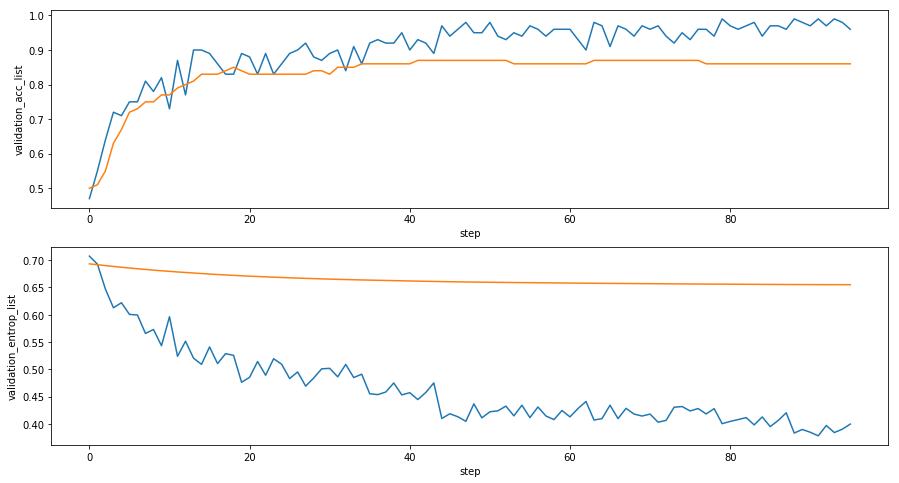

In [39]:
plt.figure(figsize=(15,8))

plt.subplot(211)
plt.xlabel("Step")
plt.ylabel("Accuracy")
sns.lineplot(x = result_list["step"], y= result_list["train_acc_list"])
sns.lineplot(x = result_list["step"], y= result_list["validation_acc_list"])


plt.subplot(212)
plt.xlabel("Step")
plt.ylabel("Cross entropy")
sns.lineplot(x = result_list["step"], y = result_list["train_entrop_list"])
sns.lineplot(x = result_list["step"], y= result_list["validation_entrop_list"])

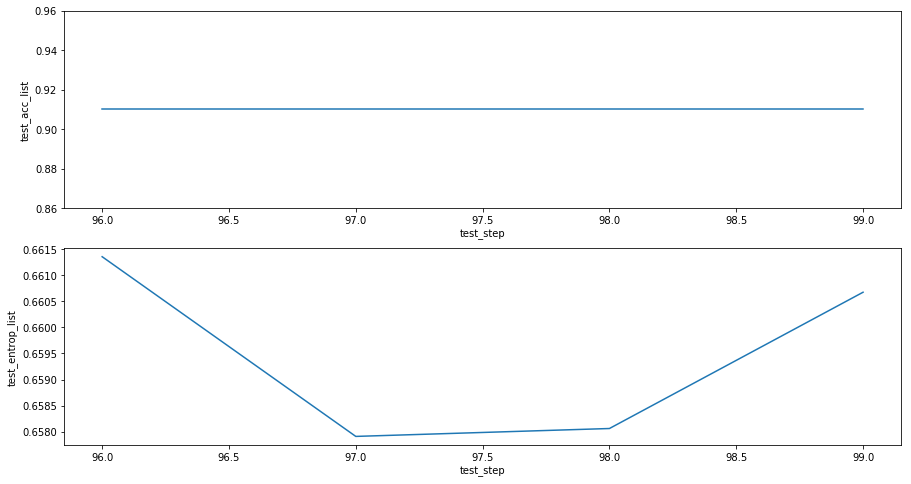

In [41]:
plt.figure(figsize=(15,8))

plt.subplot(211)
plt.xlabel("Step")
plt.ylabel("Accuracy")
sns.lineplot(x = test_result_list["test_step"], y= test_result_list["test_acc_list"])

plt.subplot(212)
plt.xlabel("Step")
plt.ylabel("Cross entropy")
sns.lineplot(x = test_result_list["test_step"], y= test_result_list["test_entrop_list"])

In [ ]:
train_acc_list = []
train_entrop_list = []

test_acc_list = []
test_entrop_list = []

validation_acc_list = []
validataion_entrop_list = []

step_list = []

lowest_loss = None

X = []
Y = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    subject_num = 1
    start = timeit.default_timer()

    for i in range(step_size):
        
        #Loading training and validation data sets
        if i%36 == 0 and i < step_size-44:
            del X
            del Y
            
            
            X, Y = load_data(subject_num, shuffle=True, nan_to_num=True, one_hot_y=True, flatten_X=True)
            
            if subject_num<57:
                subject_num +=1   
            
            elif subject_num>=57:
                subject_num =1    

        #Load test data sets
        elif i == step_size-44:    
            validate_subjec_num = 58
            X, Y = load_data(validate_subjec_num, shuffle=True, nan_to_num=True, one_hot_y=True, flatten_X=True)

        matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
        acc = tf.reduce_mean(tf.cast(matches,tf.float32))
        
        #training model
        if i < step_size-44:
            j = i%44
            _, train_entropy, train_accuracy = sess.run([train, cross_entropy, acc], 
                                                        feed_dict={x: X[j*100:j*100+100], 
                                                                   y_true: Y[j*100:j*100+100], 
                                                                   hold_prob: 0.5, is_train:True})

            validation_entropy, validation_accuracy= sess.run([cross_entropy, acc],
                                                  feed_dict={x: X[4400:4500], 
                                                             y_true: Y[4400:4500], 
                                                             hold_prob:1.0, is_train:False})
            if i%10 == 0:
                print("* * * * * * * * * * * * *")
                print('Currently on step {}'.format(i))
                print('##Train Cross entropy is: {}'.format(train_entropy))
                print('##Train Accuracy is: {}'.format(train_accuracy))
                print('\n')
                print('##Validation Cross entropy is: {}'.format(validation_entropy))
                print('##Validation Accuracy is: {}'.format(validation_accuracy))

                print("* * * * * * * * * * * * *")
                print('\n')
                
            train_acc_list.append(train_accuracy)
            train_entrop_list.append(train_entropy)
            
            validation_acc_list.append(validation_accuracy)
            validataion_entrop_list.append(validation_entropy)
            
            step_list.append(i)

        #testing model
        elif i > step_size-44:
            j = i%44
            test_entropy, test_accuracy= sess.run([cross_entropy, acc],
                                                  feed_dict={x:X[j*100:j*100+100], 
                                                             y_true:Y[j*100:j*100+100], 
                                                             hold_prob:1.0, is_train:False})

            test_acc_list.append(test_accuracy)
            test_entrop_list.append(test_entropy)
            
            step_list.append(i)
            
            if i%1 == 0:
                print("* * * * * * * * * * * * *")
                print('Currently on step {}'.format(i))
                print('##Test Cross entropy is: {}'.format(test_entropy))
                print('##Test Accuracy is: {}'.format(test_accuracy))

                print("* * * * * * * * * * * * *")
                print('\n')
                
'''
        if lowest_loss == None or lowest_loss > validation_entropy:
            lowest_loss = validation_entropy
            saver.save(sess, "./model/MPC_dnn_basic_SEMIC_binary_classification_ver4.ckpt")
'''

train_acc_list = np.array(train_acc_list)
train_entrop_list = np.array(train_entrop_list)

test_entrop_list = np.array(test_entrop_list)
test_acc_list = np.array(test_acc_list)

validation_acc_list = np.array(validation_acc_list)
validataion_entrop_list = np.array(validataion_entrop_list)

step_list = np.array(step_list)

stop = timeit.default_timer()
check_time = stop-start
now = datetime.datetime.now()

print("!!!!Finished!!!!")
print("###  Duration Time  : {} minutes   {} seconds      ###".format(int(check_time)//60, int(check_time)%60))
print("###  Excecuted Time : {}     ###".format(now))